# Part 1: Analyze the network

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
import pandas as pd

The directed network is downloaded from a .graphml file.

In [97]:
G = nx.read_graphml("new_network/new_rock_artists.graphml")

> Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.

## 1. Qualitative Analysis

The network presents 485 nodes connected by 8066 edges.

The **in-degree** of a node indicates how many artists mention that particular artist, reflecting their influence. The three artists with the highest in-degree are The Beatles, The Rolling Stones and Led Zeppelin, highly influential figures in rock music.

The **out-degree** of a node measures how many artists a node references. The artists with the highest out-degree are Alice in Chains, Deep Purple and Black Sabbath. By analysing their Wikipedia pages, their references are mostly bands that influenced them and vice versa or shared the same musical scene. These artists do not have a highly influential presence in the network but they contribute to its structure through their connections.

The **total-degree** of a node corresponds to the sum of their in and out degree, reflecting its overall connectivity. The artists with the highest total-degree are the same as the ones with highest in-degree, The Beatles, The Rolling Stones and Led Zeppelin, showing that being referenced by many others gives the node significance.

A scatter plot of in-degree versus out-degree shows that the majority of artists cluster near the origin, indicating low in-degree and low out-degree, while highly influential artists appear as outliers with very high in-degree but average out-degree.

In [98]:
no_nodes = G.number_of_nodes()
no_edges=G.number_of_edges()
print("Number of nodes:", no_nodes)
print("Number of edges:", no_edges)

#Highest in
in_degrees = dict(G.in_degree())
sorted_nodes_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)
highest_in=sorted_nodes_in[:3]
print("\nHighest in-degree nodes and their in-degree value:", highest_in)

#Highest out 
out_degrees = dict(G.out_degree())
sorted_nodes_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
highest_out=sorted_nodes_out[:3]
print(" \nHighest out-degree nodes and their out-degree value:", highest_out)

#Highest total
total_degrees = dict(G.degree())
sorted_nodes_total = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)
highest_total=sorted_nodes_total[:3]
print("\nHighest total-degree nodes and their total-degree value:", highest_total)

Number of nodes: 485
Number of edges: 8066

Highest in-degree nodes and their in-degree value: [('the beatles', 171), ('the rolling stones', 122), ('led zeppelin', 119)]
 
Highest out-degree nodes and their out-degree value: [('alice in chains', 77), ('deep purple', 76), ('black sabbath', 64)]

Highest total-degree nodes and their total-degree value: [('the beatles', 200), ('the rolling stones', 156), ('led zeppelin', 154)]


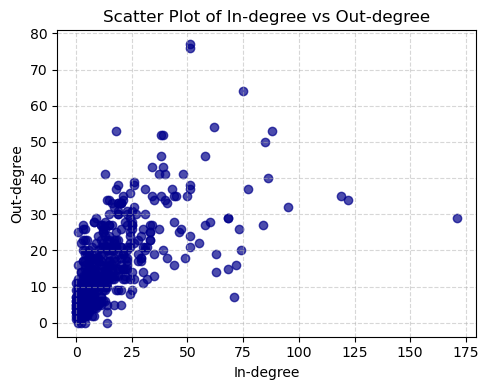

In [99]:
# in-degree and out-degree lists
in_d = [d for _, d in G.in_degree()]
out_d = [d for _, d in G.out_degree()]

plt.figure(figsize=(5, 4))
plt.scatter(in_d, out_d, marker='o', color='darkblue', alpha=0.7)
plt.title('Scatter Plot of In-degree vs Out-degree')
plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 2. Degree distributions

Since it is a directed network, analyzing the in-degree, out-degree, and total-degree distributions gives a more complete understanding of the network’s structure.

The **in-degree distribution**, $P(k_{in})$, gives the probability that a node has $k_{in}$ incoming links and reveals patterns of influence, while the **out-degree distribution**, $P(k_{out})$, gives the probability of a node having $k_{out}$  outgoing links. The **total degree distribution**, $P(k)$, combines these two and corresponds to the probability that a node has $k = k_{in} + k_{out}$ total connections in the network, representing a balance between influence and connectivity.

### 2.1. In-degree and out-degree distributions

The histogram of the network’s in-degree distribution presents a heavy-tail, meaning most artists are mentioned on only a few other artists’ pages, while a small number of artists are referenced across many pages, consistent with the patterns observed in the previous scatter plot. On a log–log plot, the distribution declines almost linearly, indicating a possible power-law behavior.

The out-degree distribution is right-skewed and long-tailed, with most nodes having between 5 and 20 out going links and only a few exceeding 40. On the log–log plot, low out-degree nodes present a high probability, while higher out-degree nodes spread downward, showing decreasing probability for nodes with more out-links. Although a few hubs exist, the pattern does not seem to follow a power law as much as the in-degree distribution.

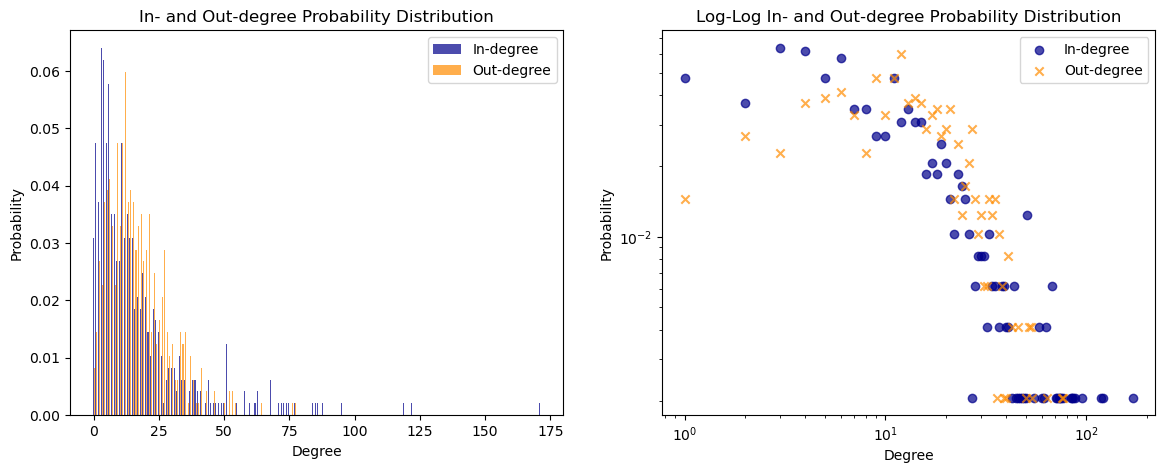

In [100]:
in_d_sort = sorted(in_d)
out_d_sort = sorted(out_d)

# bins
max_deg = max(max(in_d_sort), max(out_d_sort))
min_deg = min(min(in_d_sort), min(out_d_sort))
v = np.arange(min_deg, max_deg + 2)  

# in counts
in_counts, in_bins = np.histogram(in_d_sort, bins=v)
# in probabilities
in_probs = in_counts / in_counts.sum()

# out counts
out_counts, out_bins = np.histogram(out_d_sort, bins=v)
# out probabilities
out_probs = out_counts / out_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(v[:-1]-0.2, in_probs, width=0.4, color='darkblue', label='In-degree', alpha=0.7)
axes[0].bar(v[:-1]+0.2, out_probs, width=0.4, color='darkorange', label='Out-degree', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('In- and Out-degree Probability Distribution')
axes[0].legend()

axes[1].scatter(v[:-1], in_probs, marker='o', color='darkblue', label='In-degree', alpha=0.7)
axes[1].scatter(v[:-1], out_probs, marker='x', color='darkorange', label='Out-degree', alpha=0.7)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log In- and Out-degree Probability Distribution')
axes[1].legend()

plt.show()

A power-law distribution is defined in Equation 4.1 of Barabási’s *Network Science*, Chapter 4 [1], by:

\begin{equation}
p_k \sim k^{-\gamma}
\tag{1}
\end{equation}

where $k$ is the variable and $\gamma$ is the **scaling exponent**, which determines how quickly probabilities decrease.

To investigate if the in-degree and out-degree distributions follow a power law, their exponents were estimated using the `powerlaw` package. 

For the in-degree distribution, the result was approximately $\gamma \approx 2.7$ for $x_{min} = 19$, meaning that the power-law fit applies to degrees higher than 19. This confirms, once again, that the in-degree distribution is heavy-tailed, with its upper tail following a power-law pattern. An exponent between 2 and 3 indicates scale-free characteristics for the upper tail, where a few highly connected nodes, called hubs, play an important role in the network’s structure. In this context, while most artists are mentioned few times, artists with very high in-degree correspond to influential figures. This observation aligns with the fact that the top 3 highest in-degree nodes are famous names in the rock world.

For the out-degree distribution the exponent was approximately $\gamma \approx 5.8$ for $x_{min} = 33$. The high value of 33 means the power-law model only applies to a small portion of the data compared to the in-degree distribution. The exponent greater than 3 suggests the network does not exhibit scale-free behavior, meaning hubs are not that frequent, unlike the in-degree distribution. 

In [101]:
fit_in = powerlaw.Fit(in_d,discrete=True,verbose=False)
alpha_in = fit_in.alpha
xmin_in=fit_in.xmin
print("In-degree exponent (alpha):", alpha_in)
print("xmin:", xmin_in)

fit_out = powerlaw.Fit(out_d,discrete=True,verbose=False)
alpha_out = fit_out.alpha
xmin_out=fit_out.xmin
print("Out-degree exponent (alpha):", alpha_out)
print("xmin:", xmin_out)

In-degree exponent (alpha): 2.7123416618256444
xmin: 19.0
Out-degree exponent (alpha): 5.830719630959893
xmin: 33.0


In order to check if the distributions could follow a different model, we compared power-law, log-normal and exponential distribution models. 

For the in-degree distribution, the log-normal distribution fits the data slightly better than the power-law and exponential, although the p-value suggests this is not strong. All three models display comparable plausibility, with no strong evidence favoring one distribution over the others. Overall, the heavy-tailed behaviour indicates that most nodes have low in-degrees, while a few hubs, the highly influential artists, present many connections.

Regarding the out-degree distribution, the data, once again, does not strongly favor any particular model. In general, very few nodes have a large number of outgoing links meaning the network is dominated by typical artists with few outgoing references.

In [102]:
print("In-degree distribution model comparisons:")
R_ln_in, p_ln_in = fit_in.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln_in, ", p =", p_ln_in)

R_exp_in, p_exp_in = fit_in.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_in, ", p =", p_exp_in)

R_expln_in, p_expln_in = fit_in.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_in, ", p =", p_expln_in)

print("\nOut-degree distribution model comparisons:")
R_ln_out, p_ln_out = fit_out.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln_out, ", p =", p_ln_out)

R_exp_out, p_exp_out = fit_out.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_out, ", p =", p_exp_out)

R_expln_out, p_expln_out = fit_out.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_out, ", p =", p_expln_out)

In-degree distribution model comparisons:
Power-law vs lognormal: R = -3.429503097832927 , p = 0.0985283815914586
Power-law vs exponential: R = -0.4404399184426442 , p = 0.9278100416306371
Log-normal vs exponential: R = 2.989063179390289 , p = 0.30144117913571666

Out-degree distribution model comparisons:
Power-law vs lognormal: R = 0.00042028205398869645 , p = 0.9731733439451171
Power-law vs exponential: R = 1.1946721301773109 , p = 0.2904683182203369
Log-normal vs exponential: R = 1.1942518481233222 , p = 0.2907290336350299


c:\Users\Maria\anaconda3\envs\sgi\Lib\site-packages\powerlaw.py:1570: RuntimeWarning: invalid value encountered in divide
  return likelihoods/norm


### 2.2. Total-degree distribution

The total degree distribution is right-skewed and reflects the combination of the in-degree and out-degree distributions. Its long tail can be explained by the in-degree component, while its body comes from the moderate-in and moderate-out degrees in both distributions. It indicates that most artists have relatively few total connections, while a small number of artists have extremely high connectivity, suggesting the presence of hubs, as seen in the previous analysis. The log–log version of the plot also suggest the existence of those hubs but not a power-law behaviour.

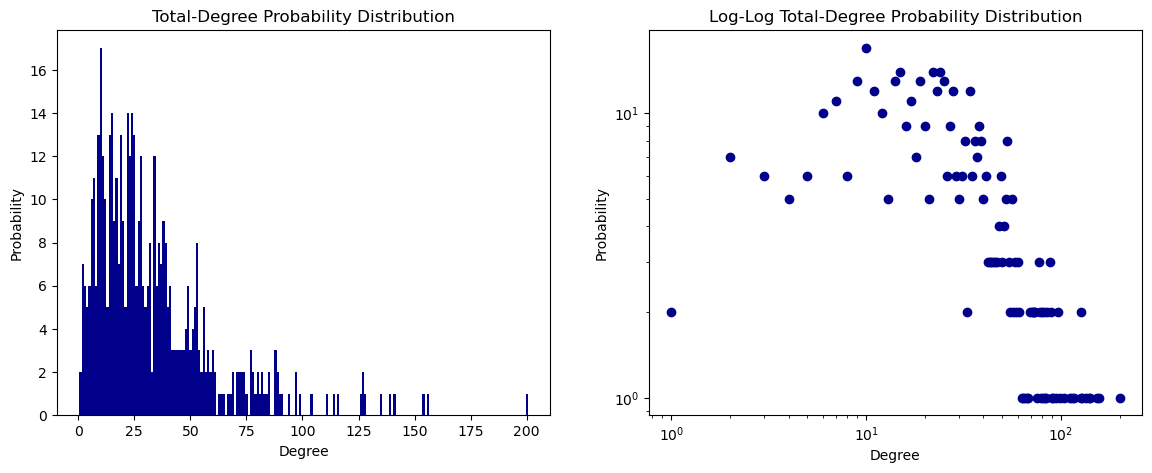

In [103]:
total_d = [d for _, d in G.degree()]
total_d_sort = sorted(total_d)

max_total=max(total_d_sort)
min_total=min(total_d_sort)
v_total=np.arange(min_total, max_total+2)

# counts
total_counts, total_bins = np.histogram(total_d_sort, bins=v_total)
# probabilities
total_probs = total_counts / total_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(total_bins[:-1], total_counts, width=np.diff(total_bins), color='darkblue')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('Total-Degree Probability Distribution')
    
axes[1].scatter(total_bins[:-1], total_counts, marker='o', color = 'darkblue')
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log Total-Degree Probability Distribution')
plt.show()

From the exponent of the degree distribution and its $x_{min}$ we can conlude the distribution does not follow a power-law. Comparison between other models was also inconclusive. In the end, the heavy-tail of the total-degree distribution reflects the real rock scene: some central figures dominate it, while most artists have smaller significance.

In [104]:
fit_total = powerlaw.Fit(total_d,discrete=True)
alpha_total = fit_total.alpha
xmin_total = fit_total.xmin
print("In-degree exponent (alpha):", alpha_total)
print("xmin:", xmin_total)

R_ln_out, p_ln_out = fit_total.distribution_compare('power_law', 'lognormal')
print("\nPower-law vs lognormal: R =", R_ln_out, ", p =", p_ln_out)

R_exp_out, p_exp_out = fit_total.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_out, ", p =", p_exp_out)

R_expln_out, p_expln_out = fit_total.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_out, ", p =", p_expln_out)

Calculating best minimal value for power law fit
In-degree exponent (alpha): 4.504202887404322
xmin: 71.0

Power-law vs lognormal: R = -0.5704999260024266 , p = 0.4609841066210114
Power-law vs exponential: R = -0.5559020941103765 , p = 0.6469807719980458
Log-normal vs exponential: R = 0.014597831892050106 , p = 0.9740817764494625


## 3. *Length-of-content* attribute

The *length-of-content* attribute represents the number of words in an artist’s Wikipedia page. The correlation between this attribute  and out and in degree is measured using Pearson’s correlation coefficient [2], which quantifies the strength and direction of a linear relationship between two variables. The correlation value between the attribute and a node’s out-degree is approximately 0.665, indicating a positive relationship. The longer an artist’s page, the more artists are mentioned on it. The correlation between *length-of-content* and in-degree is slightly higher at 0.669, suggesting that artists with longer pages also tend to be more influential. This is intuitive, since famous artists usually have more information written about them. 

In [105]:
from scipy.stats import pearsonr

length_of_content = np.array(list(nx.get_node_attributes(G, 'length_of_content').values()))
out_degree = np.array(list(dict(G.out_degree()).values()))
in_degree = np.array(list(dict(G.in_degree()).values()))

pearson_out = pearsonr(length_of_content, out_degree)
pearson_in = pearsonr(length_of_content, in_degree)
print("Pearson correlation (Out-Degree):", pearson_out[0])
print("Pearson correlation (In-Degree):", pearson_in[0])

Pearson correlation (Out-Degree): 0.6651431236717017
Pearson correlation (In-Degree): 0.6695854698018071


## 4. Centrality

Centrality measures the relative importance of nodes within a network, with different metrics capturing different aspects of that importance. We focus on three types: degree centrality, betweenness centrality and eigenvector centrality.

**In-degree** [3] **and out-degree centrality** [4] are calculated by normalizing the number of incoming or outgoing links for each node so nodes with more links are considered more central.

In [106]:
indegree_c = nx.in_degree_centrality(G)
sorted_in = sorted(indegree_c.items(), key=lambda x: x[1], reverse=True)
top5_in = [sorted_in[i][0] for i in range(5)]
print("Top 5 nodes by in-degree centrality:", top5_in)

outdegree_c = nx.out_degree_centrality(G)
sorted_out = sorted(outdegree_c.items(), key=lambda x: x[1], reverse=True)
top5_out = [sorted_out[i][0] for i in range(5)]
print("Top 5 nodes by out-degree centrality:", top5_out)

Top 5 nodes by in-degree centrality: ['the beatles', 'the rolling stones', 'led zeppelin', 'bob dylan', 'queen (band)']
Top 5 nodes by out-degree centrality: ['alice in chains', 'deep purple', 'black sabbath', "guns n' roses", 'queen (band)']


**Betweenness centrality** [5] measures how often a node lies on the shortest paths between other nodes, identifying the ones that act as bridges in the network. In a rock artist network, these nodes can represent a connection between different scenes or genres, for example, by being popular in different movements. Interestingly, the top five artists with the highest betweenness centrality also rank highly in either in-degree or out-degree centrality, suggesting a relationship between the number of connections and a node’s role as a bridge. This indicates that the Beatles are not as prominent in connecting different parts of the network as they are influential, for example.

In [107]:
bet_c=nx.betweenness_centrality(G) 
sorted_bet_c = sorted(bet_c.items(), key=lambda x: x[1], reverse=True) 
print("Top 5 nodes by betweenness centrality:")
for node, value in sorted_bet_c[:5]:
    print(f"{node}: {value:.4f}")

Top 5 nodes by betweenness centrality:
deep purple: 0.0400
queen (band): 0.0378
the rolling stones: 0.0362
alice in chains: 0.0339
guns n' roses: 0.0328


**Eigenvector centrality** [6] assigns higher scores to nodes that are connected to other highly scored nodes. In-eigenvector centrality measures importance of a node based on the importance of nodes pointing to it. Nodes with high in-eigenvector centrality are referenced by other highly influential nodes. Out-eigenvector centrality measures a node’s importance based on the importance of nodes it points to. With this centrality measure, some different artists come up as The Who, Metallica and Megadeth, that might have fewer but more important connections than the top 5 artists of degree centrality.

In [108]:
ineig_c = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06) 
top5_in = sorted(ineig_c.items(), key=lambda x: x[1], reverse=True)
print("Top 5 nodes by in-eigenvector centrality:")
for node, value in top5_in[:5]:
    print(f"{node}: {value:.4f}")

outeig_c = nx.eigenvector_centrality(G.reverse(), max_iter=1000, tol=1e-06) 
top5_out = sorted(outeig_c.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 nodes by out-eigenvector centrality:")
for node, value in top5_out[:5]:
    print(f"{node}: {value:.4f}")

Top 5 nodes by in-eigenvector centrality:
the beatles: 0.2833
the rolling stones: 0.2142
led zeppelin: 0.1962
the who: 0.1693
bob dylan: 0.1654

Top 5 nodes by out-eigenvector centrality:
alice in chains: 0.1986
deep purple: 0.1744
black sabbath: 0.1711
metallica: 0.1571
megadeth: 0.1490


### 4.1. Betweenness centrality vs degree centrality

Plotting betweenness centrality against in-degree centrality shows how a node’s role as a bridge relates to its influence in the network. The strong positive correlation of 0.832 indicates that nodes with higher betweenness centrality generally also have higher in-degree centrality. In this network, this suggests that artists who connect different parts of the network are often influential artists with many references.

Similarly, the correlation value between betweenness centrality and out-degree centrality is 0.752, slightly lower but still strong, indicating that artists who act as bridges often have high out-degree as well, though the relationship is less consistent than with in-degree.

Pearson correlation (In-Degree): 0.8320025215758797
Pearson correlation (Out-Degree): 0.7521478125219854


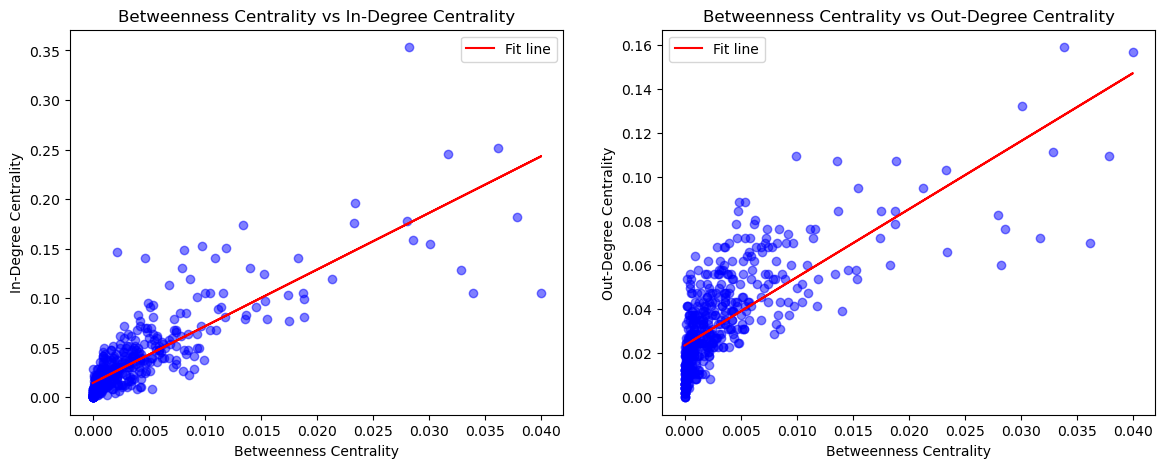

In [109]:
from scipy.stats import pearsonr

bet_c_list = list(bet_c.values())
indegree_c_list = list(indegree_c.values())
outdegree_c_list = list(outdegree_c.values())

pearson_corr_in = pearsonr(bet_c_list, indegree_c_list)
pearson_corr_out = pearsonr(bet_c_list, outdegree_c_list)
print("Pearson correlation (In-Degree):", pearson_corr_in[0])
print("Pearson correlation (Out-Degree):", pearson_corr_out[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(bet_c_list, indegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, indegree_c_list, 1)
axes[0].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"Betweenness Centrality vs In-Degree Centrality")
axes[0].set_xlabel("Betweenness Centrality")
axes[0].set_ylabel("In-Degree Centrality")
axes[0].legend()

axes[1].scatter(bet_c_list, outdegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, outdegree_c_list, 1)
axes[1].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Betweenness Centrality vs Out-Degree Centrality")
axes[1].set_xlabel("Betweenness Centrality")
axes[1].set_ylabel("Out-Degree Centrality")
axes[1].legend()
plt.show()

### 4.2. Eigenvector centrality vs degree centrality

The correlation between in-degree centrality and in-eigenvector centrality is 0.966, indicating a very strong positive relationship, as can be seen in the first plot. In-degree centrality counts how many nodes point to a node, while in-eigenvector centrality also considers the importance of those linking nodes. This means that nodes with many incoming links are generally referenced by influential nodes as well, showing that in-degree is a good measure of overall influence in the network. 

The correlation between out-degree centrality and out-eigenvector centrality is 0.89, indicating, once againa, a strong positive relationship. 
This shows that nodes that are highly active and point to many others tend to also reach important nodes.

Pearson correlation (In-Degree vs In-Eigenvector): 0.9657800599491063
Pearson correlation (Out-Degree vs Out-Eigenvector): 0.8981880637727727


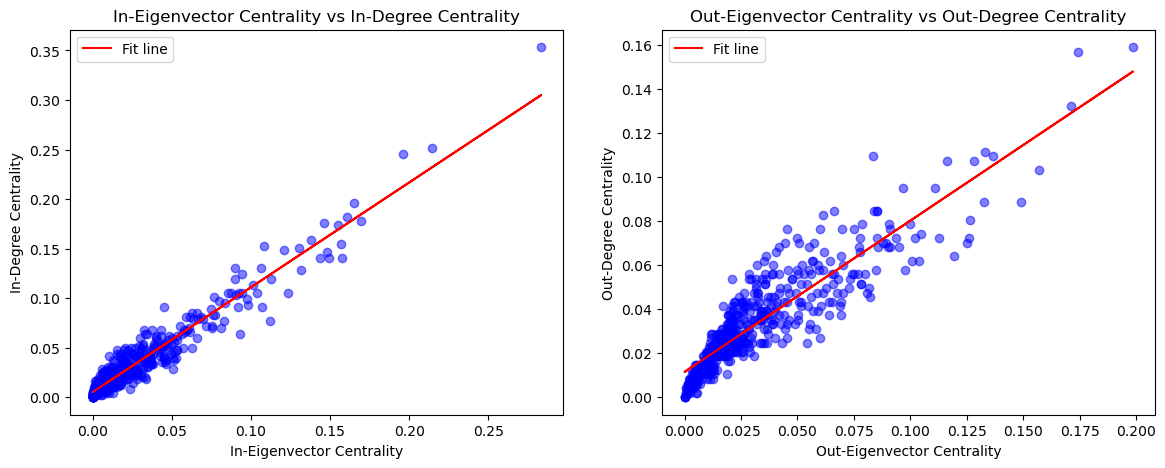

In [110]:
ineig_c_list = list(ineig_c.values())
outeig_c_list = list(outeig_c.values())

pearson_corr_in = pearsonr(ineig_c_list, indegree_c_list)
pearson_corr_out = pearsonr(outeig_c_list, outdegree_c_list)
print("Pearson correlation (In-Degree vs In-Eigenvector):", pearson_corr_in[0])
print("Pearson correlation (Out-Degree vs Out-Eigenvector):", pearson_corr_out[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(ineig_c_list, indegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(ineig_c_list, indegree_c_list, 1)
axes[0].plot(ineig_c_list, slope * np.array(ineig_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"In-Eigenvector Centrality vs In-Degree Centrality")
axes[0].set_xlabel("In-Eigenvector Centrality")
axes[0].set_ylabel("In-Degree Centrality")
axes[0].legend()

axes[1].scatter(outeig_c_list, outdegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(outeig_c_list, outdegree_c_list, 1)
axes[1].plot(outeig_c_list, slope * np.array(outeig_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Out-Eigenvector Centrality vs Out-Degree Centrality")
axes[1].set_xlabel("Out-Eigenvector Centrality")
axes[1].set_ylabel("Out-Degree Centrality")
axes[1].legend()
plt.show()

## 5. Assortativity

Assortativity measures the tendency of nodes in a network to connect to other nodes that are similar, such as by degree [7] or attribute [8].

In the case of **assortativity relative to degree**, it indicates whether high-degree nodes tend to connect with other high-degree nodes, being assortative, or with low-degree nodes, being disassortative. For this network, the assortativity value is very close to zero, meaning that connections are random with respect to degree, occurring without a preference for nodes with similar or dissimilar degree. This is not surprising given the context of the network, where both high-degree artists and low-degree artists most likely reference high-degree artists, breaking any type of assortativity pattern.

In [111]:
G_und=G.to_undirected(reciprocal=False, as_view=False)
degree_assort=nx.degree_assortativity_coefficient(G_und)
print("Degree assortativity coefficient:", degree_assort)

Degree assortativity coefficient: -0.01941766166206628


**Assortativity relative to length of content** is also very close to zero, indicating that connections are essentially random regarding the number of words on an artist’s Wikipedia page. As discussed in Section 2.2, artists with longer pages tend to have higher in-degree and therefore be more influential. Therefore, this result is not surprising since both high-degree artists (with longer pages) and low-degree artists (with shorter pages) are likely to reference highly influential artists who have longer Wikipedia pages.

In [112]:
degree_assort_length=nx.attribute_assortativity_coefficient(G_und,"length_of_content")
degree_assort_length
print("Length of content assortativity coefficient:", degree_assort_length)

Length of content assortativity coefficient: -0.003299574863728513


## 6. Backbone structure

The backbone structure of the original rock artist network was extracted using the backbone extraction package by Michele Coscia [9]. Edge betweenness centrality [10], which measures the number of shortest paths passing through each edge, was used to assign weights to the network edges, while the disparity filter from the backbone extraction package provided a significance score for each edge, allowing us to retain only the most important connections. The threshold was chosen to preserve the core structure and connectivity without excessive fragmentation, ensuring the analysis remains meaningful.

The resulting backbone network has 349 nodes connected by 419 edges and highlights the most important connections of the original network. It consists of 13 connected components, but only one forms the central cluster, as can be seen in the backbone network plot. Comparing the original network structure with the backbone, we conclude that hubs dominate both structures since a small number of artists have very high degrees. For further analysis, we will only mantain the largest component of the backbone.

In [113]:
import backboning

G_copy = G_und.copy()
edge_bet = nx.edge_betweenness_centrality(G_copy)

# normalize to [0, 100]
values = np.array(list(edge_bet.values()))
v_min, v_max = values.min(), values.max()
edge_bet_norm = 1 + 99 * (values - v_min) / (v_max - v_min)

# assign normalized weights to edges
for (edge, norm_val) in zip(edge_bet.keys(), edge_bet_norm):
    u, v = edge
    G_copy[u][v]['weight'] = norm_val

# table with src, trg and nij
edges = nx.to_pandas_edgelist(G_copy)
edges.rename(columns={'source':'src', 'target':'trg', 'weight':'nij'}, inplace=True)

# method to add score, use disparity filter
disparity_filter = backboning.disparity_filter(edges, undirected=True)
# threshold the scores and get the backbone structure
backbone_edges = backboning.thresholding(disparity_filter, threshold=0.85)

# convert table into network x
G_backbone = nx.from_pandas_edgelist(backbone_edges, source='src', target='trg', edge_attr='score')

print(f"Original Undirected Network: {len(G_copy.nodes())} nodes, {len(G_und.edges())} edges")
print(f"Backbone Network: {len(G_backbone.nodes())} nodes, {len(G_backbone.edges())} edges")

components = list(nx.connected_components(G_backbone))
print(f"\nBackbone network has {len(components)} components")
print("Sizes of components:", [len(c) for c in components])

largest_component = max(components, key=len)
G_largest = G_backbone.subgraph(largest_component).copy()

Original Undirected Network: 485 nodes, 6551 edges
Backbone Network: 349 nodes, 419 edges

Backbone network has 13 components
Sizes of components: [319, 2, 2, 2, 2, 2, 4, 2, 4, 2, 3, 3, 2]


Calculating DF score...


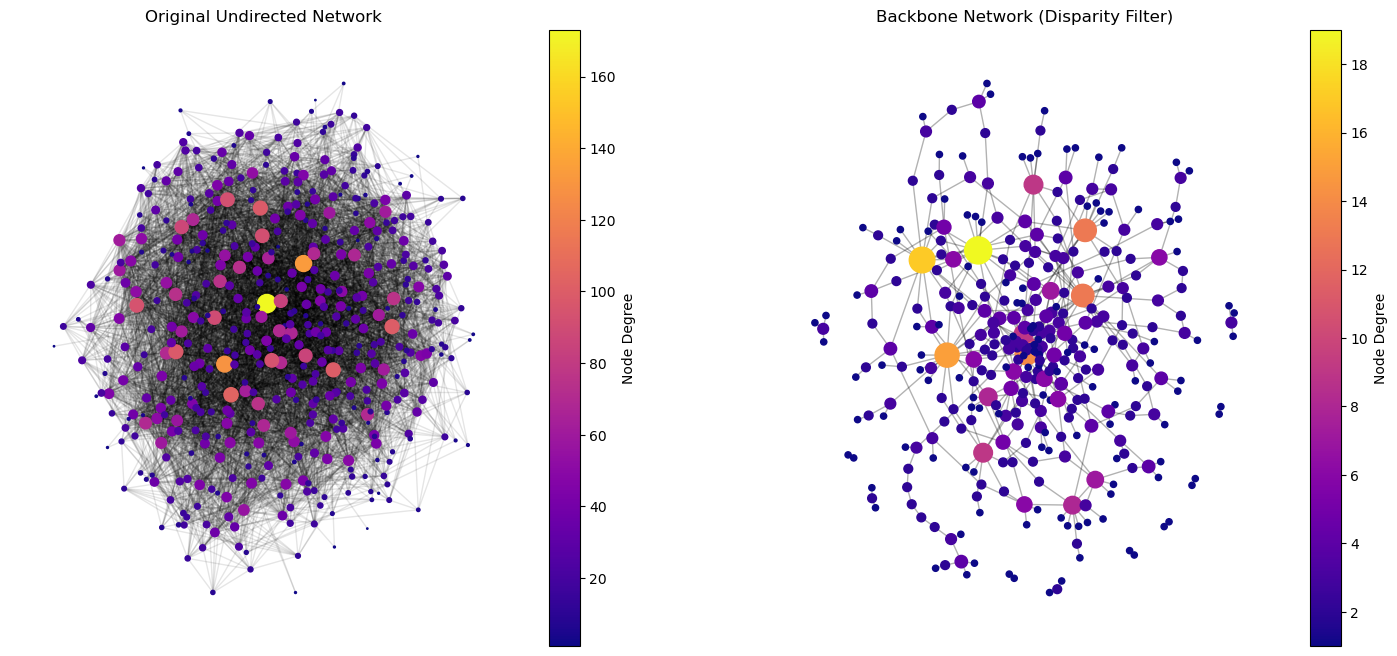

In [116]:
degrees_orig = dict(G_copy.degree())
degrees_back = dict(G_backbone.degree())

# node size
node_size_orig = [degrees_orig[n] for n in G_copy.nodes()]
node_size_back = [degrees_back[n]*20 for n in G_backbone.nodes()]

# node color
node_color_orig = [degrees_orig[n] for n in G_copy.nodes()]
node_color_back = [degrees_back[n] for n in G_backbone.nodes()]

pos_springf_orig = nx.forceatlas2_layout(G_copy, max_iter=100, gravity=25)
pos_springf_back = nx.forceatlas2_layout(G_backbone, max_iter=100, gravity=25)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
nodes_orig=nx.draw_networkx_nodes(G_copy, pos=pos_springf_orig, node_size=node_size_orig, node_color=node_color_orig, cmap=plt.cm.plasma, ax=axes[0])
nx.draw_networkx_edges(G_copy, pos=pos_springf_orig, alpha=0.1, ax=axes[0])
axes[0].set_title("Original Undirected Network")
axes[0].axis("off")
cbar_orig = plt.colorbar(nodes_orig, ax=axes[0])
cbar_orig.set_label("Node Degree")

nodes_back=nx.draw_networkx_nodes(G_backbone, pos=pos_springf_back, node_size=node_size_back, node_color=node_color_back, cmap=plt.cm.plasma, ax=axes[1])
nx.draw_networkx_edges(G_backbone, pos=pos_springf_back, alpha=0.3, ax=axes[1])
axes[1].set_title("Backbone Network (Disparity Filter)")
axes[1].axis("off")
cbar_back = plt.colorbar(nodes_back, ax=axes[1])
cbar_back.set_label("Node Degree")
plt.show()

By comparing the highest-degree nodes in the original and backbone networks, we conclude that nodes appearing in both lists are highly influential artists that also have a structural importance, as they retain key connections in the backbone.

In [117]:
# Highest degree nodes in original network
deg_orig = dict(G_copy.degree())
top_orig = sorted(deg_orig.items(), key=lambda x: x[1], reverse=True)[:10]

# Highest degree nodes in backbone network
deg_back = dict(G_largest.degree())
top_back = sorted(deg_back.items(), key=lambda x: x[1], reverse=True)[:10]

df_top = pd.DataFrame({
    "Original Network": [node for node, _ in top_orig],
    "Backbone Network": [node for node, _ in top_back],
})

print("Top 10 Highest Degree Nodes in Original and Backbone Networks:")
display(df_top)

common_nodes = set([node for node, _ in top_orig]) & set([node for node, _ in top_back])
print("\nNodes appearing in both top 10 lists:", common_nodes)

Top 10 Highest Degree Nodes in Original and Backbone Networks:


,Original Network,Backbone Network
0,the beatles,led zeppelin
1,the rolling stones,the rolling stones
2,led zeppelin,the beatles
3,queen (band),bob dylan
4,the who,jimi hendrix
5,bob dylan,deep purple
6,deep purple,elvis presley
7,metallica,alice in chains
8,black sabbath,queen (band)
9,david bowie,david bowie



Nodes appearing in both top 10 lists: {'led zeppelin', 'david bowie', 'the beatles', 'bob dylan', 'the rolling stones', 'queen (band)', 'deep purple'}


Comparing the plot of betweenness vs degree centrality of the backbone to the ones in section 4.1., **betweenness centrality** values are higher in the backbone network than in the original one, which makes sense since only the most significant edges are retained. 

Nodes with the highest betweenness centrality in the backbone, such as Led Zeppelin, Deep Purple, The Rolling Stones, The Beatles, and Elvis Presley, act as key bridges connecting different parts of the network. The correlation between **degree centrality** and **betweenness centrality** in the backbone is 0.863, indicating that these bridging nodes are likely influential artists.

On the other hand, the relationship between **eigenvector centrality** and **degree centrality** is weaker in the backbone, with a correlation of 0.548. Some nodes that had many edges in the original network still have many connections but only to less influential nodes, so their degree is relatively high in the backbone, but they are less central in terms of eigenvector centrality.

In [118]:
degree_c = nx.degree_centrality(G_largest)
bet_c = nx.betweenness_centrality(G_largest)
eigen_c = nx.eigenvector_centrality(G_largest, max_iter=1000)

sorted_degree = sorted(degree_c.items(), key=lambda x: x[1], reverse=True)
top5_deg = [sorted_degree[i][0] for i in range(5)]
print("Top 5 nodes by degree centrality:", top5_deg)

sorted_bet= sorted(bet_c.items(), key=lambda x: x[1], reverse=True)
top5_bet = [sorted_bet[i][0] for i in range(5)]
print("Top 5 nodes by betweenness centrality:", top5_bet)

sorted_eigen = sorted(eigen_c.items(), key=lambda x: x[1], reverse=True)
top5_eigen = [sorted_eigen[i][0] for i in range(5)]
print("Top 5 nodes by eigenvector centrality:", top5_eigen)

Top 5 nodes by degree centrality: ['led zeppelin', 'the rolling stones', 'the beatles', 'bob dylan', 'jimi hendrix']
Top 5 nodes by betweenness centrality: ['led zeppelin', 'deep purple', 'the rolling stones', 'the beatles', 'elvis presley']
Top 5 nodes by eigenvector centrality: ['led zeppelin', 'the rolling stones', 'korn', 'the yardbirds', 'puddle of mudd']


Pearson correlation (Betweenness vs Degree Centrality): 0.8627691488652922
Pearson correlation (Eigenvector vs Degree Centrality): 0.5476530277724512


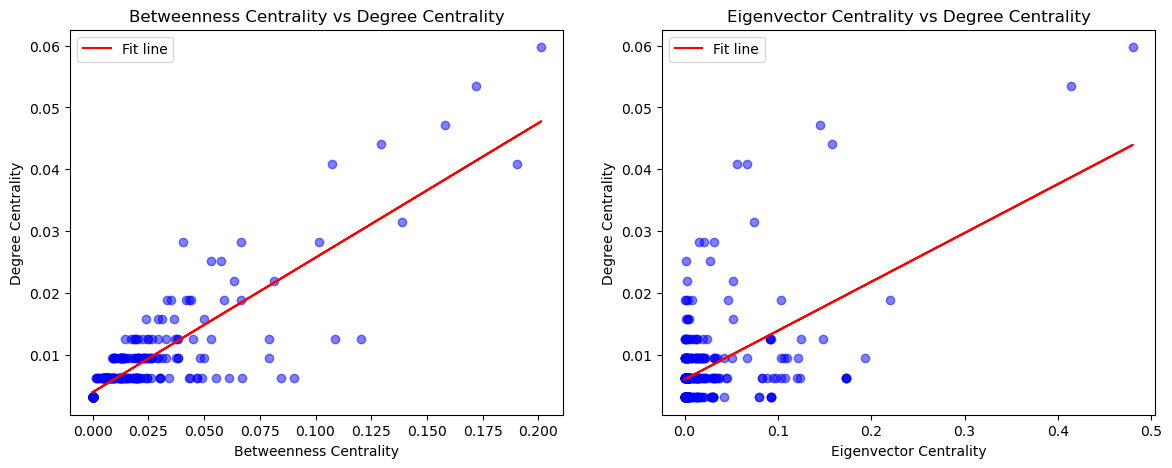

In [119]:
from scipy.stats import pearsonr

degree_c_list = list(degree_c.values())
bet_c_list = list(bet_c.values())
eigen_c_list = list(eigen_c.values())

pearson_corr_bet = pearsonr(bet_c_list, degree_c_list)
print("Pearson correlation (Betweenness vs Degree Centrality):", pearson_corr_bet[0])

pearson_corr_eig = pearsonr(eigen_c_list, degree_c_list)
print("Pearson correlation (Eigenvector vs Degree Centrality):", pearson_corr_eig[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(bet_c_list, degree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, degree_c_list, 1)
axes[0].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"Betweenness Centrality vs Degree Centrality")
axes[0].set_xlabel("Betweenness Centrality")
axes[0].set_ylabel("Degree Centrality")
axes[0].legend()

axes[1].scatter(eigen_c_list, degree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(eigen_c_list, degree_c_list, 1)
axes[1].plot(eigen_c_list, slope * np.array(eigen_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Eigenvector Centrality vs Degree Centrality")
axes[1].set_xlabel("Eigenvector Centrality")
axes[1].set_ylabel("Degree Centrality")
axes[1].legend()
plt.show()

The negative **degree assortativity**, -0.287, indicates that in the backbone network, highly connected artists tend to link to less-connected artists rather than to other highly connected hubs, highlighting a structure where influential nodes maintain connectivity across the network. Assortativity relative to length of content is very close to zero so, once again, connections are mostly random regarding the number of words on an artist’s Wikipedia page. 

In [120]:
degree_assort=nx.degree_assortativity_coefficient(G_largest)
print("Degree assortativity coefficient:", degree_assort)

degree_assort_length=nx.attribute_assortativity_coefficient(G_und,"length_of_content")
print("Length of content assortativity coefficient:", degree_assort_length)

Degree assortativity coefficient: -0.28683275261324054
Length of content assortativity coefficient: -0.003299574863728513


## 7. Conclusions

Overall, the network is dominated by hubs mostly defined by in-degree, while most artists have limited connectivity, reflecting a structure where a small number of central figures dominate and the majority are less significant. Centrality analysis shows that influential artists also act as bridges between different parts of the network and are frequently referenced by other influential nodes. Additionally, artists with higher out-degree tend to connect to important nodes, having a important role in network structure. Assortativity analysis suggests that connections are largely independent of node degree, as both high- and low-degree nodes are more likely to reference high-degree artists.

The backbone network analysis also highlights the importance of hubs. A small set of artists (Led Zeppelin, David Bowie, The Beatles, Bob Dylan, The Rolling Stones, Queen, and Deep Purple) mantain important connections in both the original and backbone networks, demonstrating both influence and structural significance. Nodes with the highest betweenness centrality in the backbone, such as Led Zeppelin, Deep Purple, The Rolling Stones, The Beatles, and Elvis Presley, serve as critical bridges. The strong correlation between degree centrality and betweenness centrality (0.863) indicates that these nodes that serve as bridges are likely highly connected. The negative degree assortativity (-0.287) shows that highly connected artists preferentially link to less-connected nodes, emphasizing once again taht influential hubs maintain connectivity across the network.

Overall, the rock artist network is characterized by a small set of influential hubs that dominate connectivity, act as bridges, and sustain the network’s backbone, while most artists play a minor role in the network, reflecting a hierarchical and asymmetric distribution of influence in the rock music scene.

# References

**[1]** Barabási, A. L. (2016). *Network Science*. Cambridge University Press. Retrieved from https://networksciencebook.com/ 

**[2]** SciPy.org. (2014). *scipy.stats.pearsonr — SciPy v0.14.0 Reference Guide*. SciPy. Retrieved from https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html

**[3]** NetworkX.org. (n.d.). *in_degree_centrality — NetworkX 3.5 documentation*. NetworkX. Retrieved from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.in_degree_centrality.html

**[4]** NetworkX.org. (n.d.). *out_degree_centrality — NetworkX 3.5 documentation*. NetworkX. Retrieved from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.out_degree_centrality.html

**[5]** NetworkX.org. (n.d.). *betweenness_centrality — NetworkX 3.5 documentation*. NetworkX. Retrieved from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html

**[6]** NetworkX.org. (n.d.). *eigenvector_centrality — NetworkX 3.5 documentation*. NetworkX. Retrieved from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html

**[7]** NetworkX.org. (n.d.). *degree_assortativity_coefficient*. NetworkX. Retrieved from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html

**[8]** NetworkX.org. (n.d.). *attribute_assortativity_coefficient*. NetworkX. Retrieved from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.attribute_assortativity_coefficient.html

**[9]** Michele Coscia. (n.d.). *Network Backboning - Michele Coscia*. Michele Coscia. Retrieved from https://www.michelecoscia.com/?page_id=287

**[10]** NetworkX.org. (n.d.). *edge_betweenness_centrality*. NetworkX. Retrieved from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.edge_betweenness_centrality.html

